## 1. Import Python libraries

In [6]:
# used to change filepaths
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

import pandas as pd
import numpy as np

# import Image from PIL
from PIL import Image

from skimage.feature import hog
from skimage.color import rgb2grey

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# import train_test_split from sklearn's model selection module
from sklearn.model_selection import train_test_split

# import SVC from sklearn's svm module
from sklearn.svm import SVC

# import accuracy_score from sklearn's metrics module
from sklearn.metrics import roc_curve, auc, accuracy_score

## 2. Display image of each bee type

,genus
id,
520,1.0
3800,1.0
3289,1.0
2695,1.0
4922,1.0


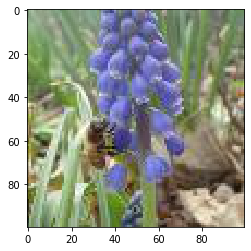

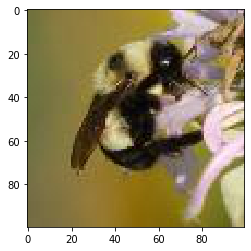

In [7]:
# load the labels using pandas
labels = pd.read_csv("datasets/labels.csv", index_col=0)

# show the first five rows of the dataframe using head
display(labels.head())

def get_image(row_id, root="datasets/"):
    """
    Converts an image number into the file path where the image is located, 
    opens the image, and returns the image as a numpy array.
    """
    filename = "{}.jpg".format(row_id)
    file_path = os.path.join(root, filename)
    img = Image.open(file_path)
    return np.array(img)

# subset the dataframe to just Apis (genus is 0.0) get the value of the sixth item in the index
apis_row = labels[labels.genus == 0.0].index[5]

# show the corresponding image of an Apis
plt.imshow(get_image(apis_row))
plt.show()

# subset the dataframe to just Bombus (genus is 1.0) get the value of the sixth item in the index
bombus_row = labels[labels.genus == 1.0].index[5]

# show the corresponding image of a Bombus
plt.imshow(get_image(bombus_row))
plt.show()

## 3. Image manipulation with rgb2grey
<p>scikit-image has a number of image processing functions built into the library, for example, converting an image to greyscale. The <a href="http://scikit-image.org/docs/dev/api/skimage.color.html#skimage.color.rgb2grey"><code>rgb2grey</code></a> function computes the luminance of an RGB image using the following formula <code>Y = 0.2125 R + 0.7154 G + 0.0721 B</code>. </p>
<p>Image data is represented as a matrix, where the depth is the number of channels. An RGB image has three channels (red, green, and blue) whereas the returned greyscale image has only one channel. Accordingly, the original color image has the dimensions <code>100x100x3</code> but after calling <code>rgb2grey</code>, the resulting greyscale image has only one channel, making the dimensions <code>100x100x1</code>.</p>

Color bombus image has shape:  (100, 100, 3)
Greyscale bombus image has shape:  (100, 100)


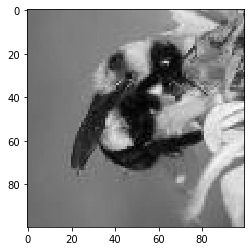

In [8]:
# load a bombus image using our get_image function and bombus_row from the previous cell
bombus = get_image(bombus_row)

# print the shape of the bombus image
print('Color bombus image has shape: ', bombus.shape)

# convert the bombus image to greyscale
grey_bombus = rgb2grey(bombus)

# show the greyscale image
plt.imshow(grey_bombus, cmap=mpl.cm.gray)

# greyscale bombus image only has one channel
print('Greyscale bombus image has shape: ', grey_bombus.shape)

## 4. Histogram of oriented gradients

<p>Now we need to turn these images into something that a machine learning algorithm can understand. Traditional computer vision techniques have relied on mathematical transforms to turn images into useful features. For example, you may want to detect edges of objects in an image, increase the contrast, or filter out particular colors.</p>
<p>We've got a matrix of pixel values, but those don't contain enough interesting information on their own for most algorithms. We need to help the algorithms along by picking out some of the salient features for them using the <a href="http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html">histogram of oriented gradients</a> (HOG) descriptor. The idea behind <a href="https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients">HOG</a> is that an object's shape within an image can be inferred by its edges, and a way to identify edges is by looking at the direction of intensity gradients (i.e. changes in luminescence). </p>

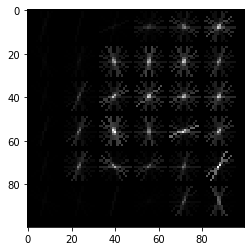

In [9]:
# run HOG using our greyscale bombus image
hog_features, hog_image = hog(grey_bombus,
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(16, 16))

# show our hog_image with a grey colormap
plt.imshow(hog_image, cmap=mpl.cm.gray)

<p>An image is divided in a grid fashion into cells, and for the pixels within each cell, a histogram of gradient directions is compiled. To improve invariance to highlights and shadows in an image, cells are block normalized, meaning an intensity value is calculated for a larger region of an image called a block and used to contrast normalize all cell-level histograms within each block. The HOG feature vector for the image is the concatenation of these cell-level histograms.</p>

## 5. Create image features and flatten into a single row

In [10]:
def create_features(img):
    # flatten three channel color image
    color_features = img.flatten()
    # convert image to greyscale
    grey_image = rgb2grey(img)
    # get HOG features from greyscale image
    hog_features = hog(grey_image, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    # combine color and hog features into a single array
    flat_features = np.hstack([color_features, hog_features])
    return flat_features

bombus_features = create_features(bombus)

# print shape of bombus_features
print(bombus_features.shape)

(31296,)


## 6. Loop over images to preprocess

In [11]:
def create_feature_matrix(label_dataframe):
    features_list = []
    
    for img_id in label_dataframe.index:
        # load image
        img = get_image(img_id)
        # get features for image
        image_features = create_features(img)
        features_list.append(image_features)
        
    # convert list of arrays into a matrix
    feature_matrix = np.array(features_list)
    return feature_matrix

# run create_feature_matrix on our dataframe of images
feature_matrix = create_feature_matrix(labels)

## 7. Scale feature matrix + PCA

In [12]:
# get shape of feature matrix
print('Feature matrix shape is: ', feature_matrix.shape)

# define standard scaler
ss = StandardScaler()
# run this on our feature matrix
bees_stand = ss.fit_transform(feature_matrix)

pca = PCA(n_components=500)
# use fit_transform to run PCA on our standardized matrix
bees_pca = pca.fit_transform(bees_stand)
# look at new shape
print('PCA matrix shape is: ', bees_pca.shape)

Feature matrix shape is:  (500, 31296)
PCA matrix shape is:  (500, 500)


## 8. Split into train and test sets

In [13]:
X_train, X_test, y_train, y_test = train_test_split(bees_pca,
                                                    labels.genus.values,
                                                    test_size=.3,
                                                    random_state=1234123)

# look at the distrubution of labels in the train set
pd.Series(y_train).value_counts()

0.0    175
1.0    175
dtype: int64

## 9. Train model: Support Vector Classifier 

In [14]:
# define support vector classifier
svm = SVC(kernel='linear', probability=True, random_state=42)

# fit model
svm.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

## 10. Score model

In [15]:
# generate predictions
y_pred = svm.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.68


## 11. ROC curve + AUC

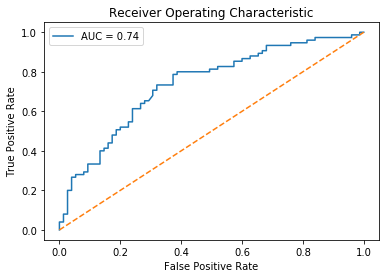

In [16]:
# predict probabilities for X_test using predict_proba
probabilities = svm.predict_proba(X_test)

# select the probabilities for label 1.0
y_proba = probabilities[:, 1]

# calculate false positive rate and true positive rate at different thresholds
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_proba, pos_label=1)

# calculate AUC
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
# plot the false positive rate on the x axis and the true positive rate on the y axis
roc_plot = plt.plot(false_positive_rate,
                    true_positive_rate,
                    label='AUC = {:0.2f}'.format(roc_auc))

plt.legend(loc=0)
plt.plot([0,1], [0,1], ls='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');